El objetivo es resolver un problema de clasificación ciruclar, tenemos 2 nubes de datos, una nube rodea a otra, y queremos ser capaces de clasificar/separar los datos.

In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

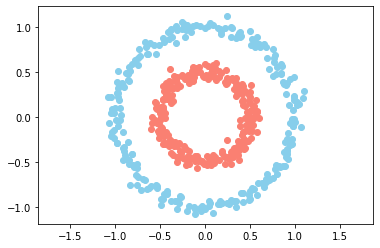

In [3]:
# Crear el dataset

n = 500 # numero de registros que tenemos en nuestros datos
p = 2 # numero caracteristicas que tenemos sobre cada dato
# Por ejemplo, si tratamos con personas tendríamos 500 personas con 2 datos que pueden ser edad y sexo
# Aquí vamos a usar 2 para simplificar la visualización de los datos

X, y = make_circles(n_samples=n, factor=0.5, noise=0.05)
y = y[:, np.newaxis]

plt.scatter(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], c="skyblue")
plt.scatter(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], c="salmon")
plt.axis("equal")
plt.show()

In [4]:
# Clase de la capa de la red

class neural_layer():
  """
    Clase para capa de neuronas, inicilizamos con
    n_conn = número de conexiones que entran en una neurona de la capa anterior
    n_neur = número de neuronas de la capa
    act_f = función de activación
  """
  def __init__(self, n_conn, n_neur, act_f):
    self.act_f = act_f
    # vector (parametro de bayes) tendremos tantos como neuronas de esta capa
    self.b = np.random.rand(1, n_neur) * 2 - 1 # random nos da valores de [0 a 1], y los queremos de [-1 a 1]
    self.W = np.random.rand(n_conn, n_neur) * 2 - 1 # matriz de pesos

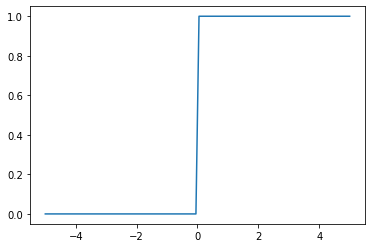

In [5]:
# Funciones de activación
sigm = (lambda x: 1 / (1 + np.exp(-x)), # función sigmoide
        lambda x: x * (1 - x)) # derivada de la función sigmoide
# Dejamos lista la derivada también para luego usarla cuando 
# utilicemos el algoritmo de backpropagation

# Para el tuto solo usamos la sigmoide,
# pero programemos las demás por amor al arte
relu = lambda x: np.maximum(0, x)
tanh = lambda x: np.tanh(x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis = 0)
linear = lambda x: x
bynary_step = lambda x: np.heaviside(x, 1)

_x = np.linspace(-5, 5, 100)
plt.plot(_x, bynary_step(_x))
plt.show()

In [6]:
# Viable? Si, pero no bonito:
# l0 = neural_layer(p, 4, sigm) # layer 0 con p conexiones (que son 2 en este caso), 4 neuronas y la funcion sigmoide
# l1 = neural_later(4, 8, sigm)
# l2 = neural_later(8, 5, sigm)
# ...



def create_nn(topology, act_f):
  nn = [] # contenedor de todas las capas de la red neuronal

  for lx, _ in enumerate(topology[:-1]): # recorrer todo hasta el último valor
    nn.append(neural_layer(topology[lx], topology[lx + 1], act_f))
  return nn 

# lista de numero de neuronas de la red, termina en 1
# pues el resultado que esperamos es binario, o pertenece a la nube
# de puntos del centro o no
topology = [p, 4, 8, 1] # topologia de la red neuronal
# se podría tener otro parametro para elegir que learning rate o que función de activación
# se va a utilizar en cada una de las capas, por ezpz vamos a usar la misma funcion de activacion
neural_net = create_nn(topology, sigm)

In [7]:
# Funcion para entrenar la red neuronal
# Paso 1: Dato de entrada y salida y se procesa hacia delante haciendo las funciones ponderadas y utilizando las funciones de activacion
# Paso 2: Se compara el resultado con el resultado real con la función de coste para tener el error, y hacemos backpropagation para
# tener las derivadas parciales y poder hacer el paso 3
# Paso 3: descenso del gradiente para optimizar la función de coste aka entrenar la red

f_coste = (lambda Ypredicha, Yreal: np.mean((Ypredicha - Yreal) ** 2), # funcion de coste (error cuadrático medio)
           lambda Ypredicha, Yreal: (Ypredicha - Yreal)) # derivada de lo anterior

def train(neural_net, X, y, f_coste, lr=0.5, train=True): # lr = learning rate

  out = [(None, X)] # vamos a guardar el resultado de la suma ponderada y de la funcion de activacion en tupla [(), (), ...]

  # Forward pass (el paso 1 vamos)
  for lx, _ in enumerate(neural_net):
    z = out[-1][1] @ neural_net[lx].W + neural_net[lx].b # suma ponderada de la 1 capa
    a = neural_net[lx].act_f[0](z) # activación
    out.append((z, a))
  
  if train:
    # Backward pass (paso 2)
    deltas = [] # error delta de las neurona en cada capa

    for l in reversed(range(0, len(neural_net))):

      z = out[l+1][0]
      a = out[l+1][1] # resultado de salida de la capa

      if(l == len(neural_net) - 1):
        # calcular delta última capa 
        # en la función de coste metemos el resultado "a" que es el de la última capa e "y" que es el esperado
        deltas.insert(0, f_coste[1](a, y) * neural_net[l].act_f[1](a)) # metemos al principio el resultado del computo del error de la última capa
      else:
        # calcular delta del resto de capas
        # se opera el delta de la pasada anterior con el valor W de la capa siguiente (que es la de atrás)
        deltas.insert(0, deltas[0] @ _W * neural_net[l].act_f[1](a))
        
      # hacemos copia de W pues en gradient descent vamos a actualizarlo,
      # y en la primera iteración entramos siempre en el if(l == len(...) - 1)
      # pues empezamos en la última capa y ahí no usamos W
      _W = neural_net[l].W.T

      # Gradient descent (paso 3)
      # neural_net[l].b -= (np.mean(deltas[0], axis=0, keepdims=True) * lr)
      neural_net[l].b -= (np.mean(deltas[0], axis=0, keepdims=True) * lr)
      neural_net[l].W -= (out[l][1].T @ deltas[0] * lr)

  return out[-1][1]

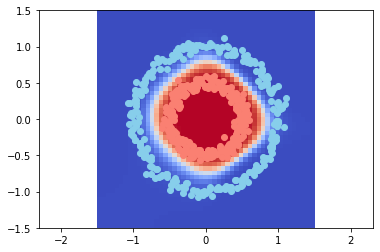

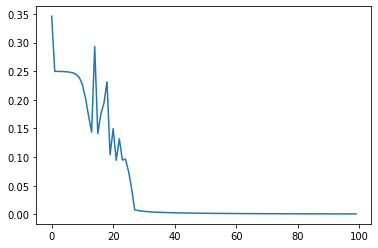

In [9]:
import time
from IPython.display import clear_output

neural_n = create_nn(topology, sigm) # nueva red neuronal

loss = [] # diferentes costes segun se vaya entrenando para graficarlo

for i in range(2500):
  # entrenemos a la red
  pY = train(neural_n, X, y, f_coste, lr=0.02)
  if(i % 25 == 0):
    loss.append(f_coste[0](pY, y))

    # resolucion para dibujar luego
    # vamos a dibujar una "malla" de 50x50
    res = 50

    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)

    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        # train esta a False por que la idea de esto es dibujar
        # una predicción de nuestra red neuronal, para ver en rojo y azul
        # la superficie que la red neuronal considera de una clase u otra clase
        _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), y, f_coste, train=False)[0][0]

    plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
    plt.axis("equal")

    plt.scatter(X[y[:, 0] == 0, 0], X[y[:,0] == 0, 1], c="skyblue")
    plt.scatter(X[y[:, 0] == 1, 0], X[y[:,0] == 1, 1], c="salmon")

    clear_output(wait=True)
    plt.show()
    plt.plot(range(len(loss)), loss)
    plt.show()
    time.sleep(0.5)